In [ ]:
import torch
torch.cuda.empty_cache()
import torchvision
import torchvision.transforms as transforms
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import csv
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)
        
  
    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def project1_model():
    layers=[1, 1, 1, 1]
    model = ResNet(BasicBlock, layers)
    return model

In [ ]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """

    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Epoch 0
Average loss: 1.5846720933914185, Average accuracy 0.5138999819755554, Training loss: 1.2804522514343262
Epoch 1
Average loss: 1.0370125770568848, Average accuracy 0.6403749585151672, Training loss: 0.9214869737625122
Epoch 2
Average loss: 0.8467320799827576, Average accuracy 0.7091874480247498, Training loss: 0.7146576046943665
Epoch 3
Average loss: 0.5334917902946472, Average accuracy 0.8130375146865845, Training loss: 0.5632983446121216
Epoch 4
Average loss: 0.4434871971607208, Average accuracy 0.8435750007629395, Training loss: 0.454313725233078
Epoch 5
Average loss: 0.3805224597454071, Average accuracy 0.8662875294685364, Training loss: 0.37765681743621826
Epoch 6
Average loss: 0.27109286189079285, Average accuracy 0.9063625335693359, Training loss: 0.30342674255371094
Epoch 7
Average loss: 0.19832058250904083, Average accuracy 0.9305124878883362, Training loss: 0.23760993778705597
Epoch 

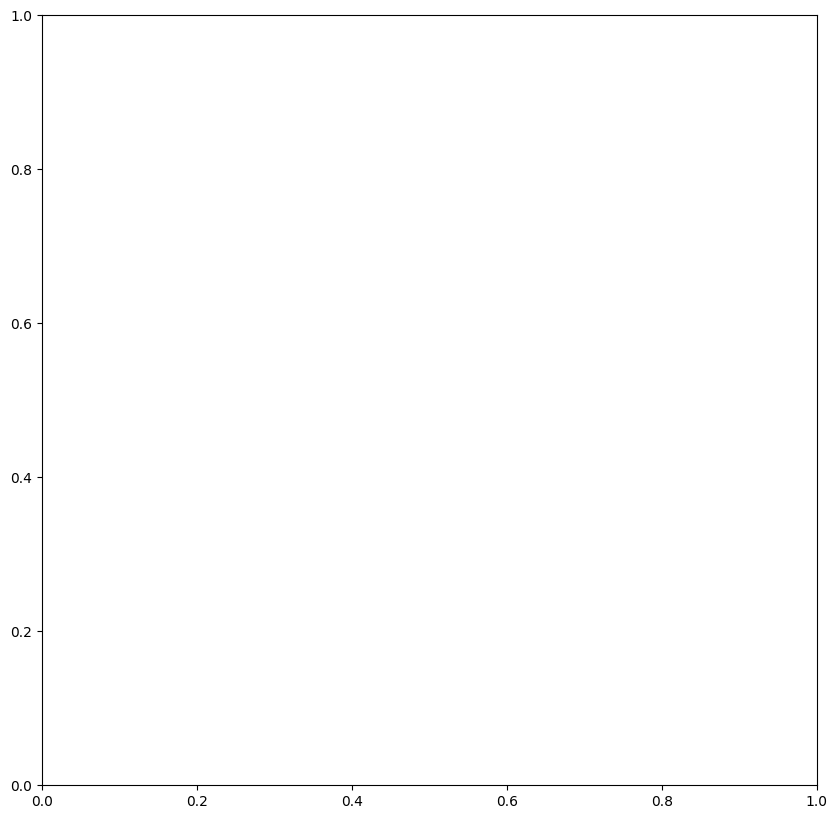

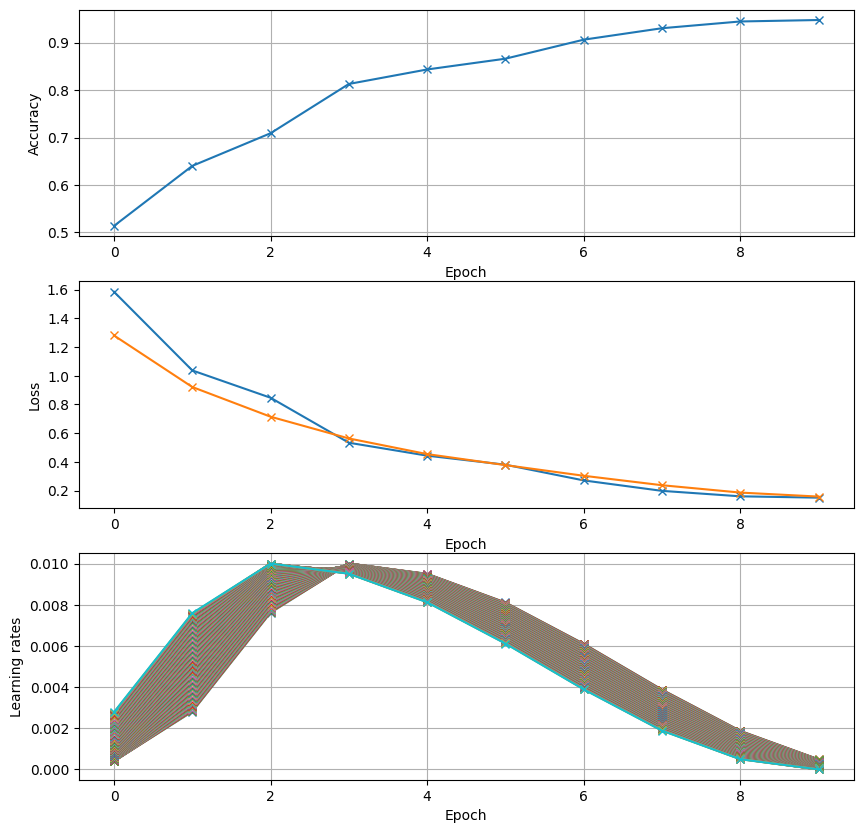

In [ ]:
data_statistics = ([0.4914, 0.4822, 0.4465],[0.2023,0.1994,0.2010])

test_transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace=True)
])

init_dataset = torchvision.datasets.CIFAR10(root="data/", download=True)
test_dataset = torchvision.datasets.CIFAR10(root="data/",download=True, train =False, transform=test_transform_cifar)
aug_dataset = init_dataset
aug_dataset.transform= transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace=True),
    Cutout(n_holes=1, length=8)
])
dataset = torch.utils.data.ConcatDataset([aug_dataset,init_dataset])

val_ratio = 0.2 
train_dataset, val_dataset = random_split(dataset, [int((1-val_ratio)* len(dataset)), int(val_ratio * len(dataset))])
batch_size = 400
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size, shuffle = True, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size, shuffle = True, pin_memory = True)

def denormalizer(images, means, std_devs):
    means = torch.tensor(means).reshape(1,3,1,1)
    std_devs = torch.tensor(std_devs).reshape(1,3,1,1)
    return images * std_devs + means

def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

def to_device(entity, device):
    if isinstance(entity, (list, tuple)):
        return [to_device(elem, device) for elem in entity]
    return entity.to(device, non_blocking = True)

class DeviceDataLoader():
    "wrapper around dataloaders to transfer batches to specified devices"
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
    
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

model = project1_model()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

if torch.cuda.is_available():
    model.cuda()

def accuracy(logits, labels):
    pred, predClassId = torch.max(logits, dim = 1) 
    return torch.tensor(torch.sum(predClassId == labels).item()/ len(logits))

def evaluate(model, dl, loss_func):
    model.eval()
    batch_losses, batch_accs = [], []                   
    for images, labels in train_dl:
        with torch.no_grad():
              logits = model(images)
        batch_losses.append(loss_func(logits, labels))
        batch_accs.append(accuracy(logits, labels))
    epoch_avg_loss = torch.stack(batch_losses).mean().item()
    epoch_avg_acc = torch.stack(batch_accs).mean()
    return epoch_avg_loss, epoch_avg_acc
    

def train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim):
    optimizer = optim(model.parameters(), max_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(train_dl))
    
    results = []
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        model.train()
        train_losses = []
        lrs = []
        for images, labels in train_dl:
            logits = model(images)
            loss = loss_func(logits, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step()
        epoch_train_loss = torch.stack(train_losses).mean().item()
                       
        model.eval()
        batch_losses, batch_accs = [], []               
        for images, labels in val_dl:
            with torch.no_grad():
                logits = model(images)
            batch_losses.append(loss_func(logits, labels))
            batch_accs.append(accuracy(logits, labels))
        epoch_avg_loss, epoch_avg_acc = evaluate(model, val_dl, loss_func)
        results.append({'avg_valid_loss': epoch_avg_loss, "avg_valid_acc": epoch_avg_acc, "avg_train_loss" : epoch_train_loss, "lrs" : lrs})
        print(f"Average loss: {epoch_avg_loss}, Average accuracy {epoch_avg_acc}, Training loss: {epoch_train_loss}")
    return results

epochs = 10
max_lr = 1e-2
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam 
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim)

plt_x = ["Epoch", "Epoch", "Epoch"]
plt_y = ["Accuracy", "Loss", "Learning rates"]
def plot(results, pairs):
    plt_count = 0
    fig, axes = plt.subplots(len(pairs), figsize = (10,10))
    for i, pair in enumerate(pairs):
        for title, graphs in pair.items():
            axes[i].se_title = title
            axes[i].legend = graphs
            axes[i]
            for graph in graphs:
                axes[i].plot([result[graph] for result in results], '-x')
                axes[i].set_xlabel(plt_x[plt_count])
                axes[i].set_ylabel(plt_y[plt_count])
                axes[i].grid()
            fig.savefig(str(title)+'.png')
        plt_count +=1 
    
    
plot(results, [{"accuracy_vs_epochs": ["avg_valid_acc"]}, {"Losses_vs_epochs" : ["avg_valid_loss", "avg_train_loss"]}, {"learning_rates_vs_batches": ["lrs"]}])

_,test_acc=evaluate(model,test_dl,loss_func)
params = count_parameters(model)
print(f"Test accuracy is {test_acc*100} %")
print(f"Parameters are: {params}")

## save model
model_path = './project1_model.pt'
torch.save(model.state_dict(), model_path)